In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
import datetime

In [3]:
color_scheme1 = plt.cm.get_cmap('tab20c')
color_scheme2 = plt.cm.get_cmap('tab20c')

In [4]:
fig_size = (13, 8)

In [5]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [6]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [7]:
def pivot_data(data_frame, column_name):
    """
    Function to extract the data by column type
    
    return a dataframe
    """
    data_frame.loc[data_frame['ncumul_conf'] == 0.0, column_name] = np.nan
    pivot = pd.DataFrame(pd.pivot_table(data_frame, 
                                        values=column_name, 
                                        index='date', 
                                        columns=['abbreviation_canton_and_fl'], 
                                        aggfunc=np.sum, 
                                        dropna=True))
    new_df = pd.DataFrame(pivot.to_records()).drop(columns="FL")
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

# Data

data from 

https://github.com/openZH/covid_19 for the data about the covid-19

https://github.com/daenuprobst/covid19-cases-switzerland for the demography and geographical data 

In [8]:
# url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/demographics.csv"

In [9]:
# demography = pd.read_csv(url, index_col="Canton")
demography = pd.read_csv("demography.csv", index_col="canton")

In [10]:
demography.to_excel(xl_writer, "Demographic data")

In [11]:
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"

In [12]:
df = pd.read_csv(url)

In [13]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'ncumul_hosp', 'ncumul_ICU', 'ncumul_vent',
       'ncumul_released', 'ncumul_deceased', 'source'],
      dtype='object')

In [14]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [15]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [16]:
df.to_excel(xl_writer, sheet_name="Raw")

# Data extraction

### Extract cases

In [17]:
cases = pivot_data(df, 'ncumul_conf')

In [18]:
cases.to_excel(xl_writer, "Cases")

In [19]:
cases_by_day = pd.concat([cases[cases.columns[0]], cases[cases.columns[1:]].diff()], axis=1)

In [20]:
cases_by_day.to_excel(xl_writer, "Cases by day")

### Extract Deaths

In [21]:
deaths = pivot_data(df, 'ncumul_deceased')

In [22]:
deaths.to_excel(xl_writer, "Deceased Cumulative")

In [24]:
# First columns is the date
daily_deaths = pd.concat([deaths[deaths.columns[0]], deaths[deaths.columns[1:]].diff()], axis=1)

In [25]:
daily_deaths.to_excel(xl_writer, "Daily Deaths")

### Extract Summary

In [26]:
df_summary = pd.concat([pd.to_numeric(cases.max().drop(['date']), downcast="integer"), 
                    pd.to_numeric(deaths.max().drop(['date']), errors='coerce', downcast="integer"),
                   demography,
                   ], 
                    axis=1)

In [27]:
df_summary.columns = ["cases", "deaths"] + list(df_summary.columns[2:])

In [28]:
df_summary.loc[df_summary["deaths"].isna(), "deaths"] = 0

In [29]:
df_summary.sort_values(by="cases", ascending=False, inplace=True)

In [30]:
df_summary.loc[df_summary["cases"] != 0, "rate"] = (df_summary["deaths"] * 100)/ df_summary["cases"]

In [31]:
df_summary["cases per million"] = df_summary["cases"].astype('int32') * 1000 / df_summary["population"]

In [32]:
df_summary["deaths per million"] = df_summary["deaths"].astype('int32') * 1000 / df_summary["population"]

In [33]:
df_summary.to_excel(xl_writer, "Summary")

In [34]:
df_summary

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
CH,26786,1306.0,8544.5,25.1,84.8,213.7,4.875681,3134.882088,152.846861
VD,4844,279.0,799.1,33.2,89.6,283.3,5.759703,6061.819547,349.142786
GE,4486,178.0,499.5,40.0,100.0,2032.1,3.967900,8980.980981,356.356356
ZH,3172,92.0,1521.0,26.9,99.3,915.8,2.900378,2085.470085,60.486522
TI,2977,270.0,353.3,27.8,92.8,129.1,9.069533,8426.266629,764.223040
VS,1707,94.0,344.0,22.7,78.8,66.0,5.506737,4962.209302,273.255814
BE,1515,55.0,1035.0,16.3,74.7,177.2,3.630363,1463.768116,53.140097
AG,960,24.0,678.2,25.1,85.0,486.1,2.500000,1415.511648,35.387791
FR,930,67.0,318.7,22.7,74.9,200.4,7.204301,2918.104801,210.229056
BS,923,37.0,194.8,36.4,100.0,5271.1,4.008667,4738.193018,189.938398


## Correlation Matrix

In [ ]:
corr = df_summary.drop("CH").corr()

In [ ]:
corr.to_excel(xl_writer, "Correlation Matrix")

In [35]:
xl_writer.close()

# Analysis Switzeland

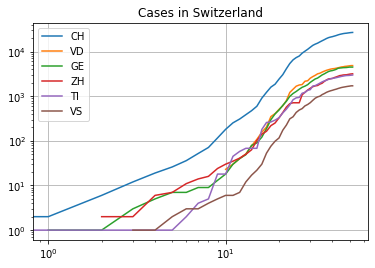

In [36]:
cases[df_summary.index[:6]].plot(logy=True, logx=True, grid=True, title="Cases in Switzerland")

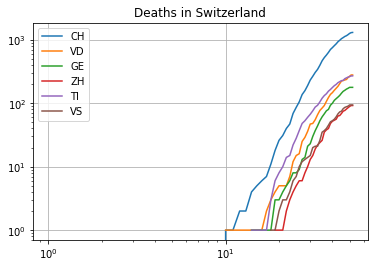

In [38]:
deaths[df_summary.index[:6]].plot(logx=True, logy=True, grid=True, title="Deaths in Switzerland")

# Analysis by Canton

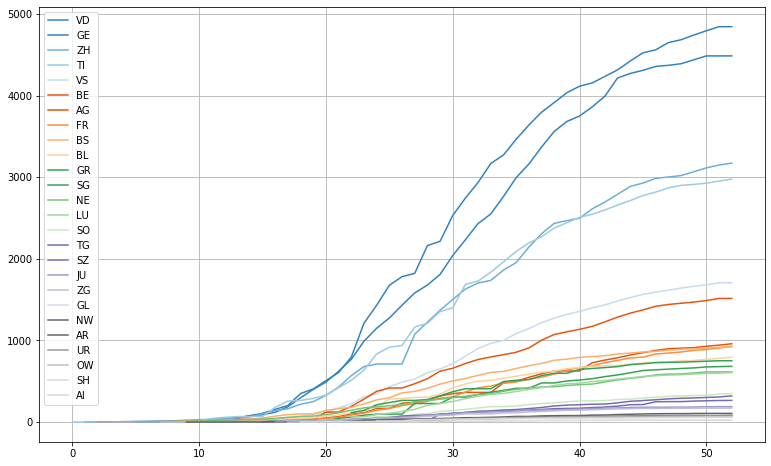

In [39]:
cases[df_summary.index[1:]].plot(figsize=fig_size, grid=True, cmap=color_scheme1)

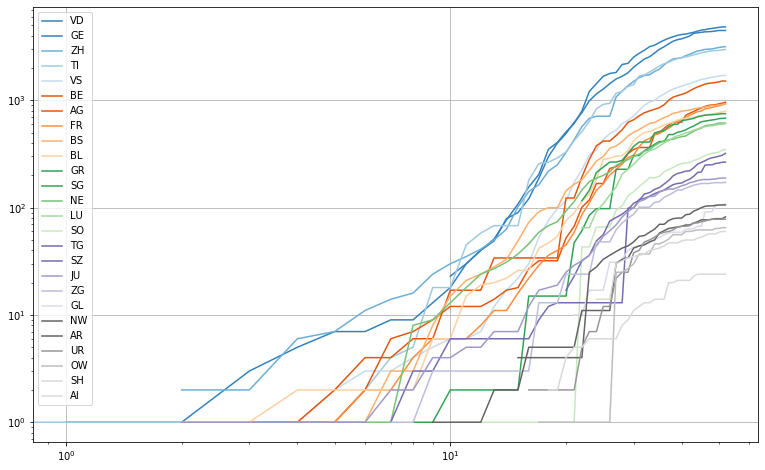

In [40]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, grid=True, cmap=color_scheme1)

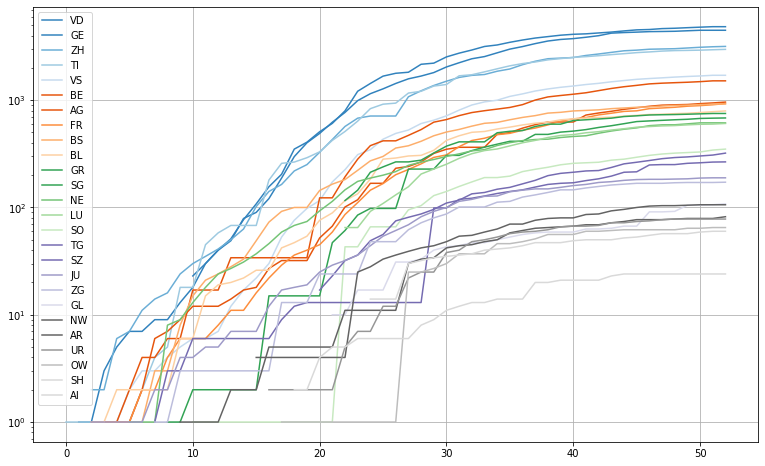

In [41]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, grid=True, cmap=color_scheme1)

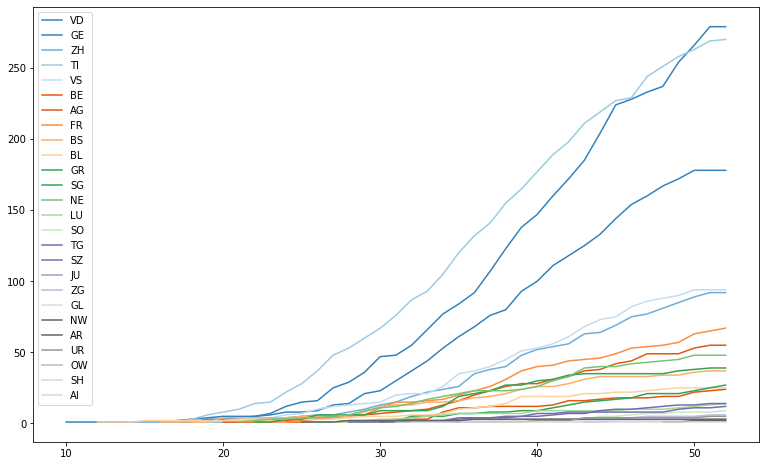

In [43]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, cmap=color_scheme1)

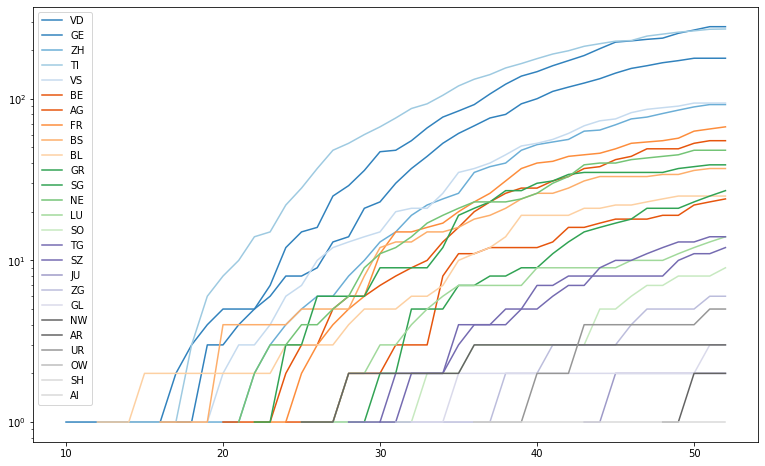

In [46]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, logy=True, cmap=color_scheme1)

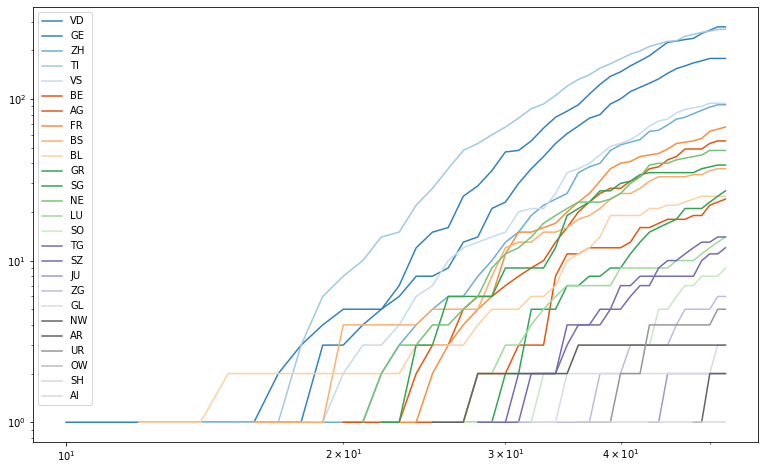

In [48]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, cmap=color_scheme1)

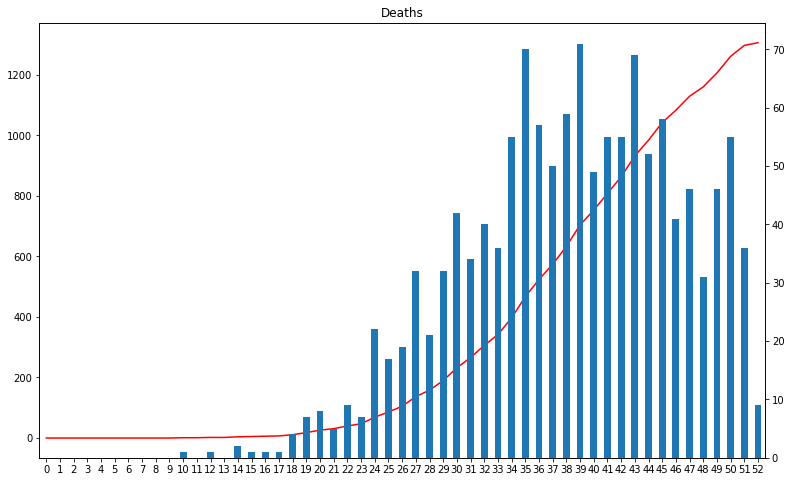

In [49]:
deaths["CH"].plot(figsize=fig_size, color="r", title="Deaths")
daily_deaths["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

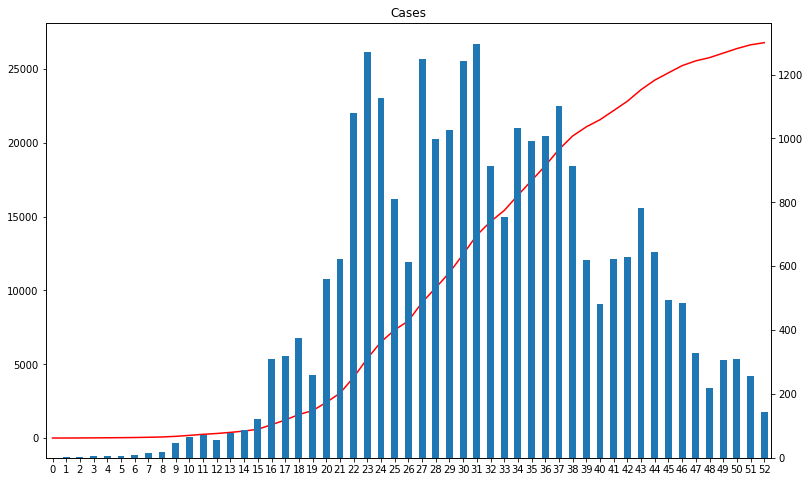

In [50]:
cases["CH"].plot(figsize=fig_size, color="r", title="Cases")
cases_by_day["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

In [52]:
ch = pd.concat([cases['CH'], deaths['CH']], axis=1)

In [53]:
ch.columns = ["Cases", "Deaths"]

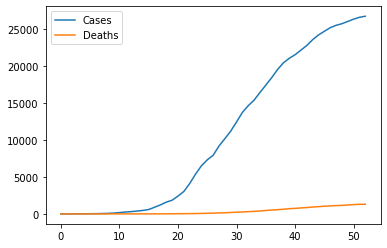

In [54]:
ch.plot()

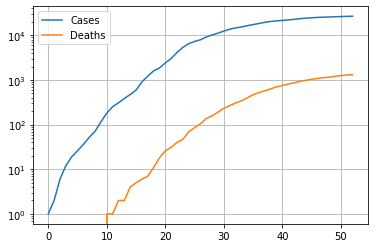

In [55]:
ch.plot(logy=True, grid=True)

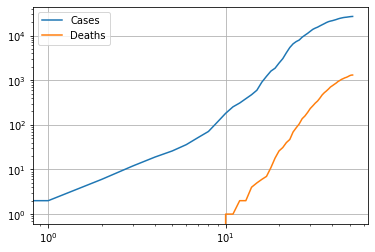

In [56]:
ch.plot(logy=True, logx=True, grid=True)

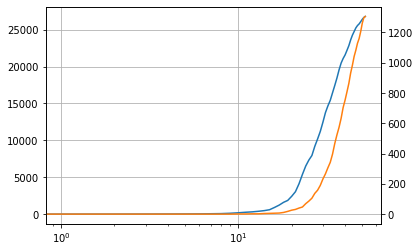

In [57]:
ch["Cases"].plot(logx=True, grid=True)
ch["Deaths"].plot(secondary_y=True, logx=True, grid=True)

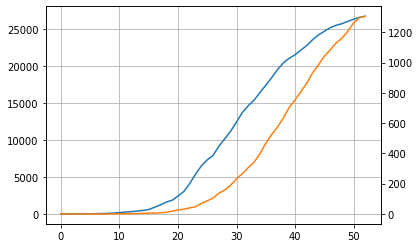

In [58]:
ch["Cases"].plot(grid=True)
ch["Deaths"].plot(secondary_y=True, grid=True)

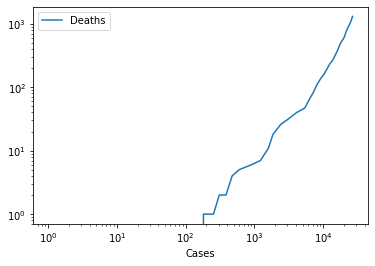

In [59]:
ch.plot(x="Cases", y="Deaths", logx=True, logy=True)

In [60]:
def plot_correlation_matrix(df):
    fig, ax = plt.subplots(figsize=(16, 16))
    im = ax.imshow(df.corr(), cmap="autumn")
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticklabels(df.columns, fontsize=12)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Correlation Matrix")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()


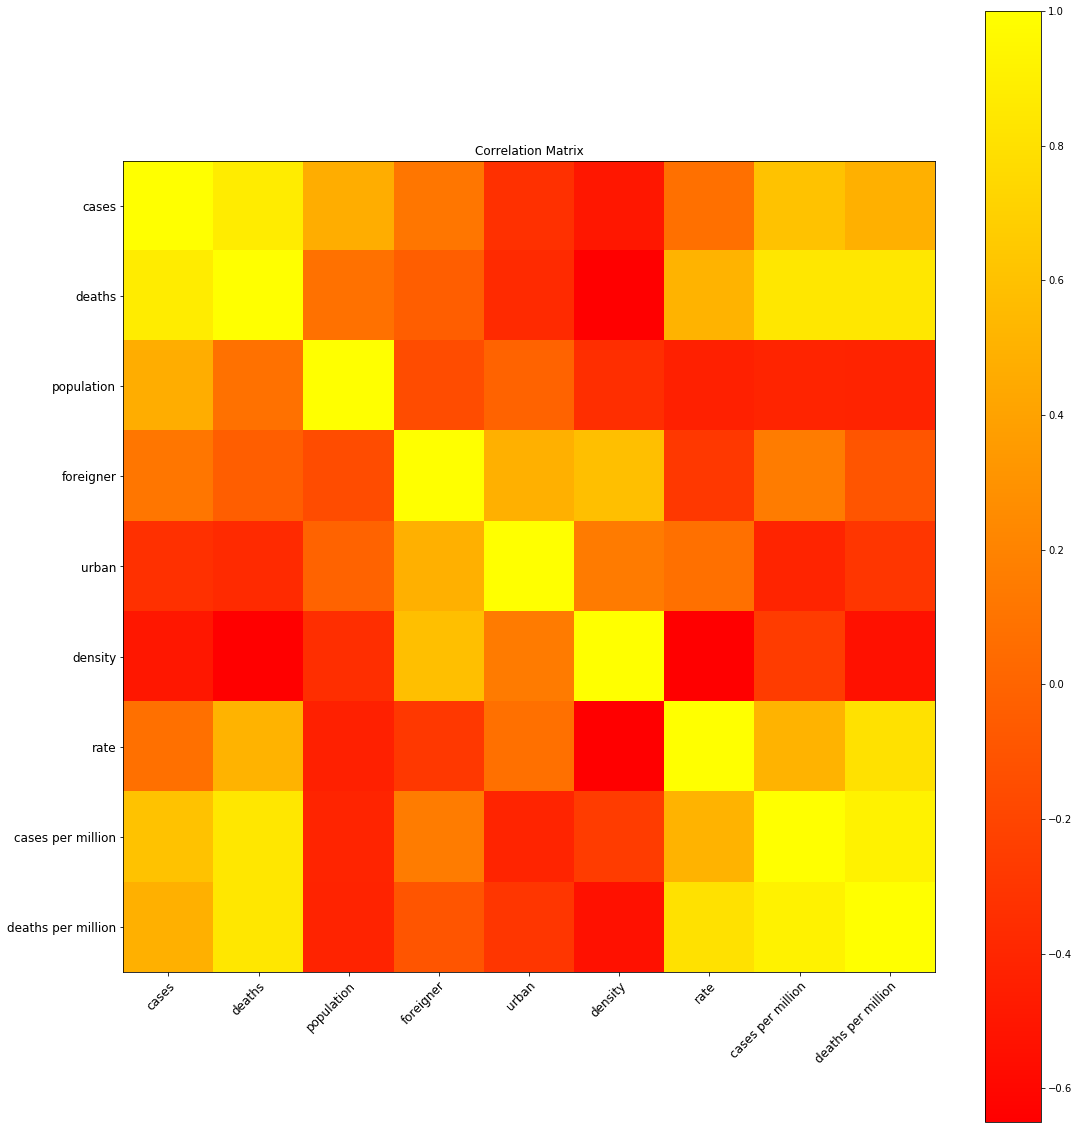

In [61]:
plot_correlation_matrix(df_summary.drop("CH").corr())

In [63]:
corr

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
cases,1.000000,0.912768,0.659168,0.646933,0.407794,0.204951,0.371785,0.764001,0.647489
deaths,0.912768,1.000000,0.447298,0.569225,0.352463,0.085652,0.567152,0.837698,0.857972
population,0.659168,0.447298,1.000000,0.325229,0.363197,0.075352,0.104628,0.118831,0.106887
foreigner,0.646933,0.569225,0.325229,1.000000,0.700555,0.608010,0.330739,0.591375,0.474330
urban,0.407794,0.352463,0.363197,0.700555,1.000000,0.357603,0.503776,0.294636,0.344089
density,0.204951,0.085652,0.075352,0.608010,0.357603,1.000000,-0.004617,0.320923,0.116268
rate,0.371785,0.567152,0.104628,0.330739,0.503776,-0.004617,1.000000,0.531459,0.773329
cases per million,0.764001,0.837698,0.118831,0.591375,0.294636,0.320923,0.531459,1.000000,0.887447
deaths per million,0.647489,0.857972,0.106887,0.474330,0.344089,0.116268,0.773329,0.887447,1.000000


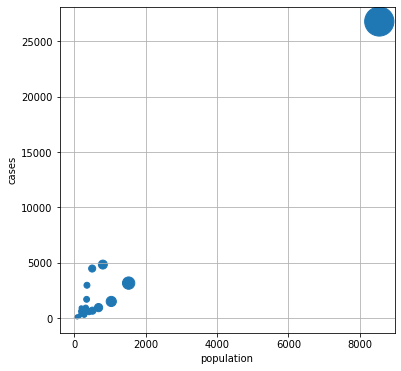

In [65]:
df_summary.plot.scatter(y="cases", 
                    x="population", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

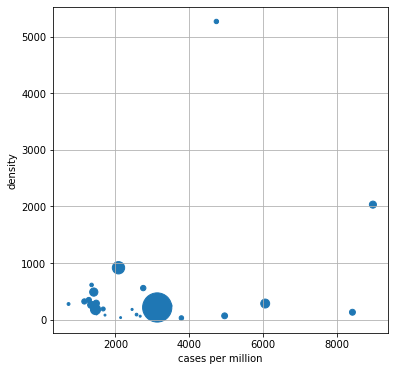

In [66]:
df_summary.plot.scatter(x="cases per million", 
                    y="density",  
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

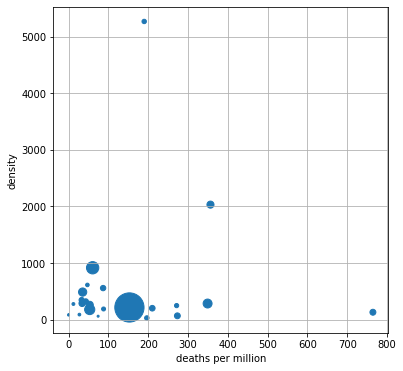

In [67]:
df_summary.plot.scatter(x="deaths per million", 
                    y="density", 
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

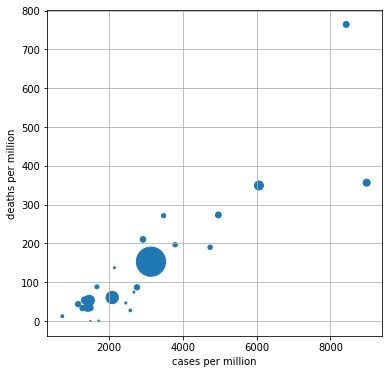

In [68]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

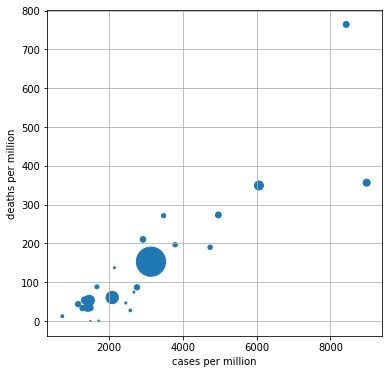

In [69]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

In [70]:
number_of_canton = 15

In [71]:
canton = pd.concat([df_summary[["cases", "deaths"]].drop("CH").iloc[:number_of_canton], 
                pd.DataFrame([df_summary[["cases", "deaths"]].drop("CH").iloc[number_of_canton:].sum(),])])

In [72]:
canton.rename(index={0: 'others'}, inplace=True)

In [73]:
canton.sort_values(by="cases", ascending=False, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0216d85950>,
      dtype=object)

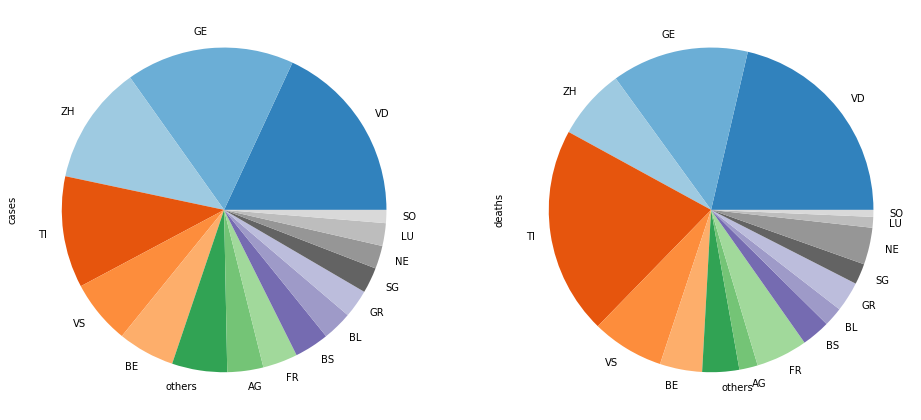

In [74]:
canton.plot.pie(subplots=True, figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'), legend=False)

In [75]:
df_summary.sort_values(by="cases per million", inplace=True, ascending=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0216cad650>,
      dtype=object)

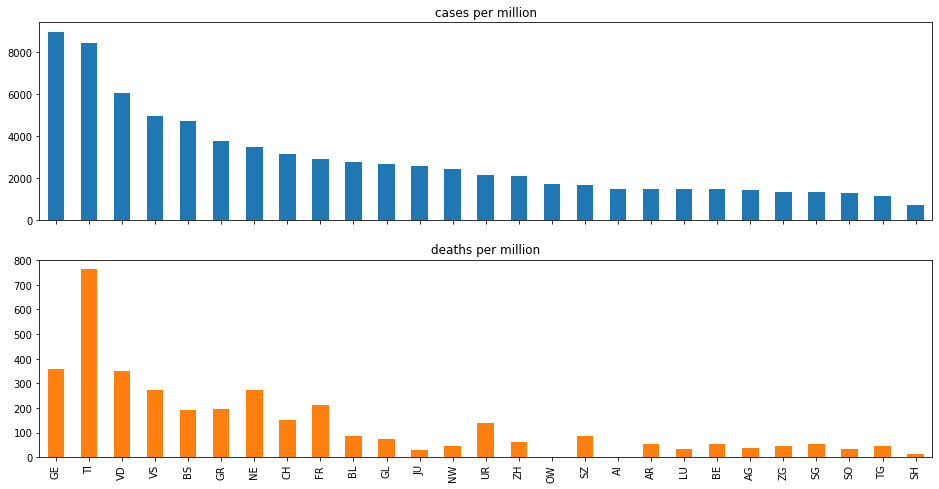

In [76]:
df_summary[["cases per million","deaths per million"]].plot.bar(subplots=True, figsize=(16, 8), legend=False)